# This notebook aims to simulate available possibility of frac scenarios based on frac.py and emitted CO2 associated with these scenarios. Later, simulated big data can be used for predictive analytics, sensitivity analysis and scenario modeling

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

In [7]:
#import of frac.py

import sys  
sys.path.insert(0, '/Users/anatolyaseev/Docs/CarbonTracker/')
import frac

# Current global variables for Monte Carlo



In [8]:
def monte_carlo_mgl(mc_sample_size = 5000):
    '''This is the function to generate monte carlo samples of global model paramters
        mc_sample_size: int, size of monte carlo samples, default = 100

        This Monte Carlo (MC) calculated for many constants and main inputs are:
        P = 13000 psi
        Q = 90 bar/min
        etta = 0.9
        t_tanks = 25
        t_pumps = 18

        For Prime Movers we used diesel and lng as a fuel, for transportation only diesel

    '''
    num_stage = np.random.randint(30,150, size = mc_sample_size)
    stage_time = np.random.randint(60,240, size = mc_sample_size)
    dis_fraction = np.random.uniform(0,1, size = mc_sample_size)
    dist_to_water = np.random.randint(0,200, size = mc_sample_size)
    truck_consumption = np.random.randint(10,25, size = mc_sample_size)
    water_per_stage = np.random.randint(100000,1000000, size = mc_sample_size)
    prop_per_stage = np.random.randint(10,100, size = mc_sample_size)
    dist_to_sand = np.random.randint(0,200, size = mc_sample_size)
    dist_to_water = np.random.randint(0,200, size = mc_sample_size)
    dist_to_fuel = np.random.randint(0,200, size = mc_sample_size)
    mob_distance = np.random.randint(1,500, size = mc_sample_size)
    sand_footprint = np.random.uniform(0,0.5, size = mc_sample_size)

    prior_mgl_samples = pd.DataFrame(data = 
                                     {'num_stage': num_stage, 
                                      'stage_time': stage_time, 
                                      'dis_fraction': dis_fraction,
                                      'dist_to_water' : dist_to_water,
                                      'truck_consumption': truck_consumption,
                                      'water_per_stage': water_per_stage,
                                      'prop_per_stage': prop_per_stage, 
                                      'dist_to_sand': dist_to_sand,
                                      'dist_to_water': dist_to_water,
                                      'dist_to_fuel': dist_to_fuel,
                                      'mob_distance': mob_distance,
                                      'sand_footprint': sand_footprint})
    
    prior_mgl_samples.to_csv("./"+str(mc_sample_size)+"_monte_carlo_parameters.csv", sep=',',index=False)
    print('Monte Carlo results of global parameters saved to file: "./' +str(mc_sample_size) + '_monte_carlo_parameters.csv"')

In [9]:
def monte_carlo_mdh(f_m_tablefile):
    # INPUTS
    fname_parameters = f_m_tablefile
    df = pd.read_csv(fname_parameters)
    fname = 'fracCO2' # Name your simulation
    # Define parameters
    num_stage = df['num_stage'].values
    stage_time = df['stage_time'].values
    dis_fraction = df['dis_fraction'].values
    truck_consumption = df['truck_consumption'].values
    water_per_stage = df['water_per_stage'].values
    prop_per_stage = df['prop_per_stage'].values
    dist_to_sand = df['dist_to_sand'].values
    dist_to_water = df['dist_to_water'].values
    dist_to_fuel = df['dist_to_fuel'].values
    mob_distance = df['mob_distance'].values
    sand_footprint = df['sand_footprint'].values

    
    nrealizations = len(df)

    CO2prediction = np.zeros(nrealizations)
    for i in tqdm(range(nrealizations)):
        F = frac.Frac('conv', stage_time[i], num_stage[i], 13000, 90, 25, 18)
        primeMover = F.primeMover(0, dis_fraction[i], 0, 1 - dis_fraction[i], 0)

        sandTransport = F.sandTransport(prop_per_stage[i], 24, dist_to_sand[i], truck_consumption[i])
        waterTransport = F.waterTransport(water_per_stage[i], 20, dist_to_water[i], truck_consumption[i])
        fuelTransport = F.fuelTransport(10, dist_to_fuel[i], truck_consumption[i])

        materialTransport = sandTransport + waterTransport + fuelTransport
        mobDemob = F.mobDemob(mob_distance[i], truck_consumption[i])
        land = F.land()
        sandMining = F.sandMining(prop_per_stage[i], sand_footprint[i])
        people  = F.people()
        auxillary = F.auxillary()

        CO2prediction[i] = primeMover + materialTransport + mobDemob + land + sandMining + people + auxillary
        
    return CO2prediction

In [10]:
sample_size = 5000
monte_carlo_mgl(mc_sample_size = sample_size)

Monte Carlo results of global parameters saved to file: "./5000_monte_carlo_parameters.csv"


In [11]:
f_m_tablefile = str(sample_size) + '_monte_carlo_parameters.csv'
fracCO2 = monte_carlo_mdh(f_m_tablefile)
np.save('fracCO2_5000', fracCO2)

In [2]:
fracCO2_5000 = np.load('fracCO2_5000.npy')

In [3]:
import plotly.express as px

fracCO2_tons = fracCO2_5000 / 1000
fig = px.histogram(fracCO2_tons, title = 'CO2 emissions from frac, tons')
fig.update_layout(showlegend=False)
fig.show()

# Sensitivity part. We take our table with all variables and check which one brings more uncertainty on overall frac CO2 emissions

In [4]:
from DGSA_Light.DGSA_light import DGSA_light
from DGSA_Light.gsa_pareto_plt import gsa_pareto_plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
model_var = np.expand_dims(fracCO2_5000, axis=1)

In [6]:
# Load global model parameters
f_m_tablefile = pd.read_csv('5000_monte_carlo_parameters.csv')
f_m_tablefile.head()

,num_stage,stage_time,dis_fraction,dist_to_water,truck_consumption,water_per_stage,prop_per_stage,dist_to_sand,dist_to_fuel,mob_distance,sand_footprint
0,31,108,0.952281,8,24,276172,44,108,84,110,0.461776
1,63,161,0.648152,2,23,329604,38,172,109,230,0.395098
2,103,200,0.047482,41,20,134739,54,84,99,295,0.068377
3,60,156,0.431388,77,16,914864,33,162,61,319,0.351311
4,120,182,0.456036,110,22,138787,16,198,156,182,0.008477


In [7]:
global_vars = f_m_tablefile
names = global_vars.columns.values.tolist()

In [8]:
dgsa_global_variables_to_model = DGSA_light(global_vars.to_numpy(), model_var, ParametersNames = names)

100%|██████████| 3000/3000 [00:11<00:00, 254.55it/s]


In [11]:
import matplotlib.pyplot as plt

def gsa_pareto_plt(GSA_dataframe):
    
    '''
    Pareto plot to display sensitivity analysis results. 
    Args:
        GSA_dataframe: main sensitivity of parameters measured from DGSA, (pd.DataFrame)data frame. 
        
    Output:
        Pareto Plot for the GSA
    '''
    
    GSA_dataframe = GSA_dataframe.sort_values(by=0, ascending=False)

    #############Define the colour bar #########
    n_parameter = len(GSA_dataframe)
    n_sensitive = len(GSA_dataframe.values[GSA_dataframe.values >=1])
    if n_parameter>=20:
        if n_parameter - n_sensitive > 6: 
            n_plt_para = len(GSA_dataframe.values[GSA_dataframe.values >=1])+6
        else:
            n_plt_para = n_parameter
    else:
        n_plt_para = n_parameter
        
    pltdata = GSA_dataframe.values[:n_plt_para,0]
    
    mask= pltdata <= 1
    ### red
    colors = np.asarray([[1, 0, 0, 1.0]]*n_plt_para)
    ###blue
    colors[mask] = [0, 0, 1, 1.0]
    #### red
    #colors[:,3]= (abs(pltdata-max(pltdata[mask]))/abs(max(pltdata)-max(pltdata[mask])))**0.3
    #### blue
    #colors[:,3][mask]= (np.sqrt(colors[mask][:,3]/(max(colors[mask][:,3]))))**2

    plt.figure(figsize=(12,5))
    plt.bar(np.arange(n_plt_para), pltdata, width=0.85, color = colors,edgecolor='k', linewidth=0.5,)
    plt.xlim([-0.6,n_plt_para])
    #if max(pltdata[:n_plt_para])>3:
    #    plt.ylim([min(pltdata[:n_plt_para]-0.2), 3])
    #else:
    #    plt.ylim([min(pltdata[:n_plt_para]-0.2), max(pltdata[:n_plt_para]+0.05)])
    plt.xticks(np.arange(n_plt_para), GSA_dataframe.index[:n_plt_para], fontsize=15, rotation =70)
    plt.yticks(fontsize=16)
    plt.axhline(y=1, linestyle = '--', c ='k')
    plt.ylabel('Sensitivity measurements', fontsize=16)
    plt.title('Global sensitivity of parameters to CO2 emissions', fontsize=18, loc='left', style='italic')
    plt.xlabel('Parameters', fontsize=17)

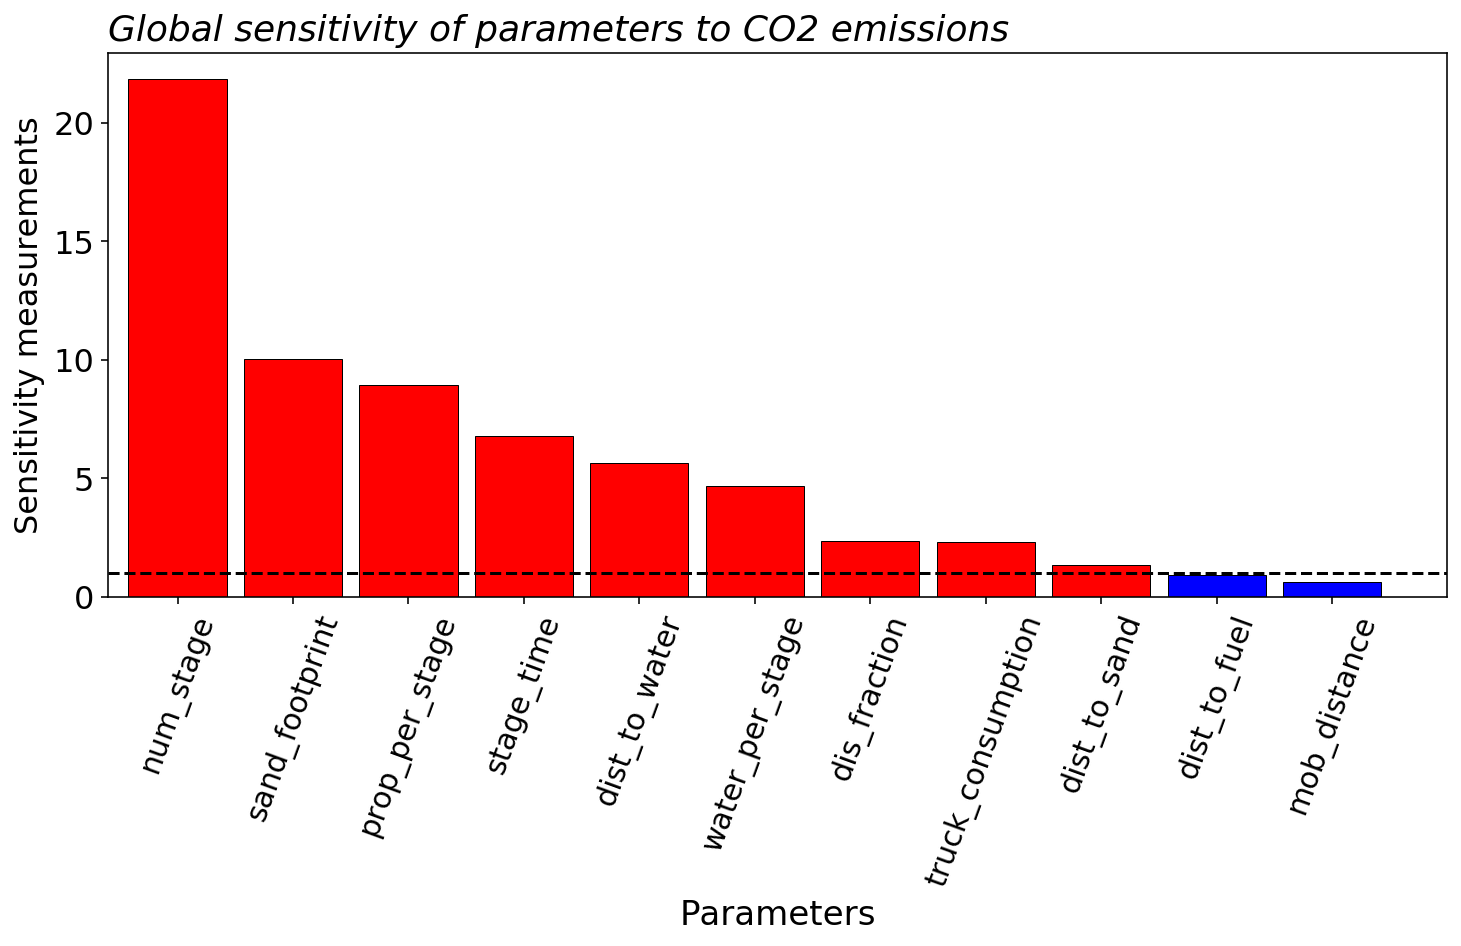

In [12]:
gsa_pareto_plt(dgsa_global_variables_to_model)